In [1]:
import csv
import numpy as np
import itertools as it
from numpy import savetxt
from scipy import integrate
import pandas as pd
import matplotlib.pyplot as plt
from math import e

For this project we have chosen a model from Titcombe2002. Although, the proposed mathematical model should be perceived as an abstract generalisation, it has been proven to explain behavioral clinical symptoms among patients with DBS implants Titcombe2002.


Brain dynamics is modelled as a three-unit network, where each node represents an impulse response gathered from a neuron population:

$$\frac{dy_1}{dt}=f_1(y_3)-y_1 ,
\frac{dy_i}{dt}=f_E(y_{i-1}), \hspace{1cm} i=2,3 \hspace{6cm} (1)$$

Where $f_1$ is an Inhibitory response function:

$$f_1(y)=\frac{\Theta^g}{y^g + \Theta^g} \hspace{11cm} (2)$$, 

and $f_E$ is an  Excitatory response function:

$$f_E(y)= \frac{y^g}{y^g+ \Theta^g}, \Theta=0.5 \hspace{9cm} (3)$$

The unit exhibits a Hopf bifurcation at $g=\mu_c =4$, for $g< \mu_c =4$ it has one stable point, for $g>\mu_c =4$ it has a stable limit cycle. 

The stimulation can be modelled as:

$$ g(t)=g_0-z(t), \frac{dz}{dt}=-\frac{1}{t_c}z \hspace{9cm} (4)$$

where $z(t)$ is a released substance in each stimulus. $Z(t)$ constantly decays with a time constant $t_c$. Without stimulation $z$ decays to zero. 
This stimulus model is coherent with the recent studies, which show that neurotransmitters' increase builds up after a brain stimulation \citep{Titcombe2002}.

Every stimulation a particular amount ($\delta$) of the substance ($z$) is released per period ($\tau$) with the frequency ($f$) equals to $\frac{1}{\tau}$. Thus, 
$$z(t) = z_0 e^{-\frac{n\tau}{t_c}}+ \frac{\delta(e^{-\frac{n\tau}{t_c}} - 1)}{1- e^{\frac{\tau}{t_c}}}. \hspace{8cm} (5)$$ 

Based on that, we can finally determine \emph{g} by the following equation:

$$g(t)=g_0 - \frac{\delta(e^{t/t_c} - 1)}{1- e^{\tau/t_c}} \hspace{9cm} (6) $$

In [2]:
#Sampling Parameters
steps = 100
time_step = 0.1
noise = 0.2

# noise = [np.random.normal(0.0, 0.4, size=time_step) for time_step in steps]
t = np.linspace(0, steps, int(steps/time_step))

#Stimulation parameters

z_init = 0 #stimulation
t_c = 1.16 #time constant with which effect of stimulation decays
tau_init = 100 #stimulation period
f_init = 1/tau_init #(stimulation frequency == 100 Hz)
delta_init = 1/60 # stimulation amplitude

# Initial state of 3-node system
y_1_0 =0.02
y_2_0 =0.02
y_3_0 =0.015
u_init=0
g_init = 6  #bifrcation parameter at g=4
y_init = (y_1_0,y_2_0,y_2_0)

theta = 0.5 # units’ threshold


In [3]:
#Hill functions for neuron connections 

def f_inh(y, theta, g):   #Inhibition
    y = theta**g/(y**g+theta**g)
    return y                  #monotonically decreasing sigmoidal function
    
    
    
def f_ex(y,theta,g): #Exitation
    y = y**g/(y**g+theta**g)
    return y               #monotonically increasing sigmoidal function
    

In [4]:
#Network

def three_nodes_model(y_init, t, g, noise, theta= 0.5):
        
        y_1_dot = f_inh(y_init[2],theta,g) - y_init[0] +noise
        y_2_dot = f_ex(y_init[0], theta,g) - y_init[1] +noise
        y_3_dot = f_ex(y_init[1], theta,g) - y_init[2] +noise
        
        return [y_1_dot,  y_2_dot,  y_3_dot]
    
    



In [5]:
#Stimulation simplified for integrating
def stimulation(stim_init, t, t_c=t_c): 
            
            z_dot= -stim_init[0]/t_c  # z_dot = -z/t_c
            stim_init[1] = 6-z_dot
            return [z_dot,stim_init[1]]
      

In [6]:
#Stimulation simplified 
def stimulation(z, t, t_c=t_c): 
            z = -z/t_c
            return z
      

In [7]:
def g_value(z,t,g_init=6):
    u=integrate.odeint(stimulation, z, t)
    g = g_init-u
    return g,u

In [8]:
g,u = g_value(5,t)

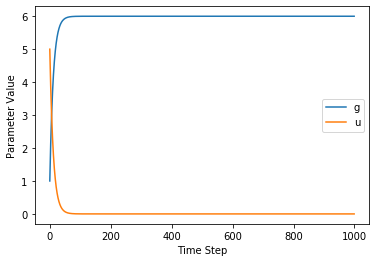

In [9]:
plt.plot(g, label="g") 
plt.plot(u, label="u")
plt.xlabel("Time Step")
plt.ylabel("Parameter Value")
plt.legend()

In [10]:
#Stimulation simplified 
def stimulation_inegrated(z, z_dot = 0, g=6, t_c=t_c):
        if g>0 and z>0:
            z_dot = z-z_dot - t_c
            g = g-z_dot
            return g, z_dot
        else:
            g=g
            return g, 0

In [11]:
#Stimulation with parameters
def stimulation_with_param(delta, tau,g=6, t_c=t_c):
    z_dot =(delta*(e**(t_c)-1))/(1-e**(tau/t_c))
    if z_dot>0:
            z_dot= -z_dot - t_c
            g = g-z_dot
            return [g, z_dot]
    else:
            g=g
            return [g, 0]

In [12]:
def three_nodes_model_with_stim(y_init, t, z, noise,theta= 0.5):
       
        z = stimulation(z,t)
        g = 6-stimulation(z,t)
        y_1_dot = f_inh(y_init[2],theta,g) - y_init[0] +noise
        y_2_dot = f_ex(y_init[0], theta,g) - y_init[1] +noise
        y_3_dot = f_ex(y_init[1], theta,g) - y_init[2] +noise
        
        return [y_1_dot,  y_2_dot,  y_3_dot]
    

In [13]:
def three_nodes_model_with_stim_param(y_init, t, delta, tau, noise,theta= 0.5):
       
        g,z = stimulation_with_param(delta, tau)
   
        y_1_dot = f_inh(y_init[2],theta,g) - y_init[0] +noise
        y_2_dot = f_ex(y_init[0], theta,g) - y_init[1] +noise
        y_3_dot = f_ex(y_init[1], theta,g) - y_init[2] +noise
        
        return [y_1_dot,  y_2_dot,  y_3_dot, z, g]
    

### Data Generation

mostly commented, as through the project we generated different datasets with different parameters

In [254]:
# node_values_st_param = []
# for i in range(12):
#         if i==0:
#             t = np.linspace(1, 5, int(10))
#             values = integrate.odeint(three_nodes_model_with_stim_param, y_init, t, (0,0,
#                                                                    0.002))
    
            
#             node_values_st_param = values
  
#         elif  i%2==0:
#             t = np.linspace(1, 5, int(100))
#             values=integrate.odeint(three_nodes_model_with_stim_param, 
#                                   node_values_st[-1,:], t, (delta_init, tau_init,
#                                                                       0.002))
        
     
#             node_values_st_param=np.concatenate((node_values_st_param,values))
# #             node_values[-1:3]=0
        
#         else:
        
#             t = np.linspace(1, 10, int(100))
#             values = integrate.odeint(three_nodes_model_with_stim_param, node_values_st[-1,:], 
#                                   t, (0,0,
#                                                                       0.002))
        
#             node_values_st_param=np.concatenate((node_values_st_param,values))

In [657]:
# node_values_st_1,node_values_st_2, node_values_st_3, node_values_st_4=[],[],[],[]
# node_values_sts = [node_values_st_1, node_values_st_2, node_values_st_3, node_values_st_4]
# stimulation_vec = []

# for n in range(4):
#     for i in range(12):
#         if i==0:
#             t = np.linspace(1, 5, int(10))
#             values = integrate.odeint(three_nodes_model_with_stim, y_init, t, (0,
#                                                                    0.002))
    
            
#             node_values_st = values
#             stimulation_vec  = np.zeros(len(t))
  
#         elif  i%2==0:
#             t = np.linspace(1, 5, int(100))
#             z=get_stim_vector(5,t)
            
#             values=integrate.odeint(three_nodes_model_with_stim, 
#                                   node_values_st[-1,:], t, (z[t],
#                                                                       0.002))
        
     
#             node_values_st=np.concatenate((node_values_st,values))
#             stimulation_vec  = np.concatenate((stimulation_vec,z))

        
#         else:
        
#             t = np.linspace(1, 10, int(100))
# #             values = integrate.odeint(three_nodes_model_with_stim, node_values_st[-1,:], 
#                                   t, (0,
#                                                                       0.002))
        
#             node_values_st=np.concatenate((node_values_st,values))
#             stimulation_vec  = np.concatenate((stimulation_vec, np.zeros(len(t))))
            
# #     node_values_sts[n]=node_values_st






In [698]:
# node_values_st_1,node_values_st_2, node_values_st_3, node_values_st_4=[],[],[],[]
# node_values_sts = [node_values_st_1, node_values_st_2, node_values_st_3, node_values_st_4]
# z = [0.043,4,5,6]

# for n in range(4):
#     for i in range(12):
#         if i==0:
#             t = np.linspace(1, 5, int(10))
#             values = integrate.odeint(three_nodes_model_with_stim, y_init, t, (0,
#                                                                    0.002))
    
            
#             node_values_st = values
  
#         elif  i%2==0:
#             t = np.linspace(1, 10, int(100))
#             values=integrate.odeint(three_nodes_model_with_stim, 
#                                   node_values_st[-1,:], t, (z[n],
#                                                                       0.002))
        
     
#             node_values_st=np.concatenate((node_values_st,values))
# #             node_values[-1:3]=0
        
#         else:
        
#             t = np.linspace(1, 10, int(100))
#             values = integrate.odeint(three_nodes_model_with_stim, node_values_st[-1,:], 
#                                   t, (0,
#                                                                       0.002))
        
#             node_values_st=np.concatenate((node_values_st,values))
            
#     node_values_sts[n]=node_values_st

/Users/maria_p/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/Users/maria_p/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/maria_p/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [665]:
# values = node_values_sts[0]d
# plt.plot(values[:,:3])

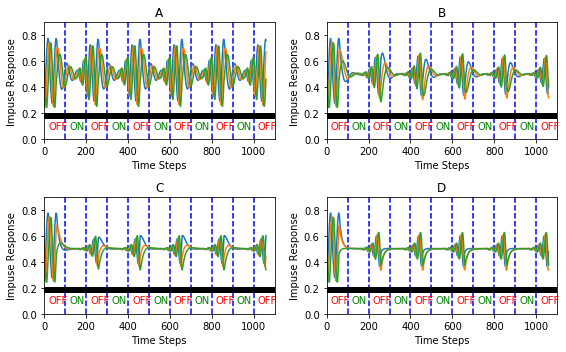

In [517]:
# fig, ax = plt.subplots(2,2, figsize=[8,5])
# r=0
# for i in range(2):
#     for j in range(2):
#         values = node_values_sts[r]
#         ax[i,j].plot(values[50:,:3])
#         ax[i,j].set_xlabel("Time Steps")
#         ax[i,j].set_title(titles[i,j])
#         ax[i,j].set_ylabel("Impuse Response")
#         ax[i,j].axis([0, 1100, 0, 0.9])
#         ax[i,j].vlines(np.arange(1,11)*100, 0,9, "blue", "--")
#         ax[i,j].hlines(0.18, 0, 1100,linewidth=6, color= "black")
#         for l in np.arange(120,1000,200):
#              ax[i,j].annotate("ON",xy=(l,0.08), color="green")
#         for l in np.arange(20,1100,200):
#              ax[i,j].annotate("OFF",xy=(l,0.08),color="red")
#         r+=1
        
# plt.tight_layout()

In [505]:
# titles=["A", "B", "C", "D"]
# titles = np.reshape(titles,((2,2)))

In [660]:
# fig, ax = plt.subplots(2,2, figsize=[8,5])
# r=0
# for i in range(2):
#     for j in range(2):
#         values = node_values_sts[r]
#         ax[i,j].plot(values[50:,:3])
#         ax[i,j].set_xlabel("Time Steps")
#         ax[i,j].set_title(titles[i,j])
#         ax[i,j].set_ylabel("Impuse Response")
#         ax[i,j].axis([0, 1100, 0, 0.9])
#         ax[i,j].vlines(np.arange(1,11)*100, 0,9, "blue", "--")
#         ax[i,j].hlines(0.18, 0, 1100,linewidth=6, color= "black")
#         for l in np.arabnge(120,1000,200):
#              ax[i,j].annotate("ON",xy=(l,0.08), color="green")
#         for l in np.arange(20,1100,200):
#              ax[i,j].annotate("OFF",xy=(l,0.08),color="red")
#         r+=1
        
# plt.tight_layout()

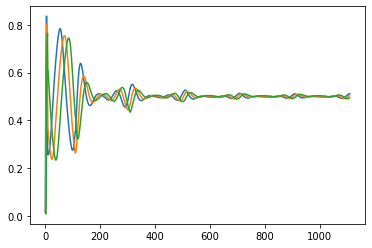

In [661]:
for i in range(12):
        if i==0:
            t = np.linspace(1, 5, int(10))
            values = integrate.odeint(three_nodes_model_with_stim, y_init, t, (0,
                                                                   0.002))
    
            
            node_values_st = values
  
        elif  i%2==0:
            t = np.linspace(1, 10, int(100))
            values=integrate.odeint(three_nodes_model_with_stim, 
                                  node_values_st[-1,:], t, (0.09,
                                                                      0.002))
        
     
            node_values_st=np.concatenate((node_values_st,values))
#             node_values[-1:3]=0
        
        else:
        
            t = np.linspace(1, 5, int(100))
            values = integrate.odeint(three_nodes_model_with_stim, node_values_st[-1,:], 
                                  t, (0,
                                                                      0.002))
        
            node_values_st=np.concatenate((node_values_st,values))
            
#         node_values_sts[n]=node_values_st
        
        
plt.plot(node_values_st[:,:3])

In [662]:
# node_values_st = []
# for i in range(12):
#         if i==0:
#             t = np.linspace(1, 5, int(10))
#             values = integrate.odeint(three_nodes_model_with_stim, y_init, t, (0,
#                                                                    0.002))
    
            
#             node_values_st = values
  
#         elif  i%2==0:
#             t = np.linspace(1, 5, int(100))
#             values=integrate.odeint(three_nodes_model_with_stim, 
#                                   node_values_st[-1,:], t, (z[n],
#                                                                       0.002))
        
     
#             node_values_st=np.concatenate((node_values_st,values))
# #             node_values[-1:3]=0
        
#         else:
        
#             t = np.linspace(1, 10, int(100))
#             values = integrate.odeint(three_nodes_model_with_stim, node_values_st[-1,:], 
#                                   t, (0,
#                                                                       0.002))
        
#             node_values_st=np.concatenate((node_values_st,values))

/Users/maria_p/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/maria_p/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


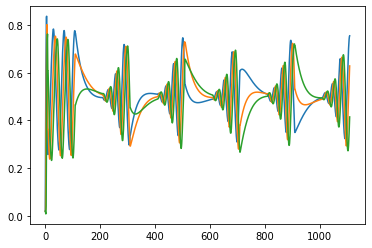

In [663]:
# #Simulation of the system. Apply stimulation == 5 every 100 step
# node_values = [] #list to save the values 

# for i in range(12):
#     #10s to make a system oscilate
#     if i==0:
#         t = np.linspace(1, 5, int(10))
#         values = integrate.odeint(three_nodes_model, y_init, t, (6,
#                                                                    0))
#         values=np.insert(values, 3, values=0, axis=1) #record stimulation parameter 
#                                                      #for ML
#         node_values=values   # save values
        

#     elif  i%2==0: #apply stimulation
#         t = np.linspace(1, 5, int(100))
#         values = integrate.odeint(three_nodes_model, 
#                                   node_values[-1,:3] #start node values from the previous step 
#                                   , t, (1,0)) # g=1, so u=5. 
        
#         values=np.insert(values, 3, values=5, axis=1)
#         node_values=np.concatenate((node_values,values))
        
#     else: # no stimulation
        
#         t = np.linspace(1, 10, int(100))
#         values = integrate.odeint(three_nodes_model, node_values[-1,:3], t, (6,
#                                                                       0))
        
#         values=np.insert(values, 3, values=0, axis=1)
#         node_values=np.concatenate((node_values,values))

# node_values5 = node_values        
# plt.plot(node_values[:,:3])

# savetxt('data_for_DMDc_high_freq_test.csv', node_values[10:], delimiter=',')

### Plot model dynamics with different stimulation parameters 

In [664]:
# grapg_list=[node_values, node_values3[:,:3], node_values2[:,:3], node_values1[:,:3] ]
# grapg_list = np.reshape(grapg_list,((2,2)))
# titles=["A", "B", "C", "D"]
# titles = np.reshape(titles,((2,2)))

In [519]:
# fig, ax = plt.subplots(2,2, figsize=(10, 5)) 
# for n in range(2):
#     for m in range(2):

#         ax[n,m].plot(grapg_list[n,m])
#         ax[n,m].set_xlabel("Time Steps")
#         ax[n,m].set_title(titles[n,m])
#         ax[n,m].set_ylabel("Impuse Response")
#         ax[n,m].axis([0, 1100, 0, 0.9])
#         ax[n,m].vlines(np.arange(1,11)*100, 0,9, "blue", "--")
#         ax[n,m].hlines(0.18, 0, 1100,linewidth=6, color= "black")
#         for i in np.arange(120,1000,200):
#             ax[n,m].annotate("ON",xy=(i,0.08), color="green")
#         for i in np.arange(20,1100,200):
#             ax[n,m].annotate("OFF",xy=(i,0.08),color="red")
            
# plt.tight_layout()
# #         for i in np.arange(0,1200,200):
# #             ax[n,m].axvspan(xmin=i, xmax=i+100, color="gray")
# #         for i in np.arange(100,1200,200):
# #             ax[n,m].axvspan(xmin=i, xmax=i+100)

# # ax[0,1].plot(node_values1[:,:3])


# # ax[1,0].plot(node_values2[:,:3])
# # ax[1,1].plot(node_values3[:,:3])





In [91]:
# savetxt('data_off_test.csv', values[98:], delimiter=',')

In [66]:
#Create data set with random g, thus random oscilattions. 

# bif_param = []
# model_values = []

# for i in range(100):
#     g = np.random.randint(2,9)
#     node_values = integrate.odeint(three_nodes_model, y_init, t, (g,0))
#     for j in range(node_values.shape[0]):
#         model_values.append((np.append(node_values[j],g)))
  


    

In [67]:
# savetxt('three_nodes_data2_1000g.csv', model_values, delimiter=',')